## Requirements

- Python 3.7

In [72]:
import sys
if (sys.version_info.major, sys.version_info.minor) == (3, 7):
    print(f"Python version OK")
else:
    print("Incorrect Python version, must be 3.7")

Python version OK


In [ ]:
import os

def check_module(module, install=True, upgrade=True):
    try:
        __import__(module)
        print(f"Module '{module}' OK")
        if upgrade:
            print(f"Upgrading '{module}'...")
            print(os.popen(f"pip install --user -U {module.replace('_', '-')}").read())
        
    except ModuleNotFoundError:
        print(f"Module '{module}' not found")
        if install:
            print(f"Installing '{module}'......")
            print(os.popen(f"pip install --user {module.replace('_', '-')}").read())
            print('Installed')
            check_module(module)

- Modules to install

In [ ]:
modules = [
    'struct',
    'numpy',
    'time',
    'atexit',
    'logging',
    'glob',
    'PyQt5',
    'scipy',
    'seaborn',
    'matplotlib',
    'pyqtgraph',
    'mne',
    'sklearn',
    'joblib'
]

[check_module(module) for module in modules];

## Import modules 

In [1]:
from MIfunctions import *
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from scipy.signal import filtfilt, butter
import matplotlib.pyplot as plt
from joblib import dump, load
import open_bci as bci
import numpy as np
from numpy import matlib
import seaborn as sns
import time as tm
import struct
import serial
import mne

## Connection and acquisition

- Board connection

In [2]:
baud = 115200
board = bci.OpenBCIBoard(port=None, baud = baud, filter_data = True)
print("EEG Channels :",board.eeg_channels_per_sample)
print("Aux Channels :",board.aux_channels_per_sample)


Searching Board...
Serial established...
OpenBCI V3 8-16 channel
On Board ADS1299 Device ID: 0x3E
LIS3DH Device ID: 0x33
Firmware: v3.1.1
$$$
Connecting to V3 at port /dev/ttyUSB0
EEG Channels : 8
Aux Channels : 3


- Parameters for acquisition

In [3]:
fs = 250.0                     # Sample Frequency
START_BYTE = 0xA0               
END_BYTE = 0xC0                 
TIME = 6                       #Seconds to read
Adquic = int(TIME*fs)          #Samples to read
eeg_raw = []                   #Save raw data

- Stream mode activated

In [4]:
board.ser.write(b'b')
board.streaming = True

- Good reading of data

In [5]:
def read(n):
    b = board.ser.read(n)
    if not b:
        board.warn('Device appears to be stalled. Quitting...')
        sys.exit()
        raise Exception('Device Stalled')
        sys.exit()
        return '\xFF'
    else:
        return b
    

Read_state:
- 0 means that is looking for the start byte
- 1 means that is acquiring data from EEG channels.
- 2 means that is acquiring accelerometer data.
- 3 means that is looking for the end byte

In [6]:
max_bytes_to_skip=10000
board.read_state = 0

def read_data(board, max_bytes_to_skip):
    for rep in range(max_bytes_to_skip):
        
        if board.read_state == 0:
            b = read(1)
            
            if struct.unpack('B', b)[0] == START_BYTE:
                #print("START BYTE FOUND: ",b)
                if(rep != 0):
                    #board.warn('Skipped %d bytes before start found' %(rep))
                    rep = 0;
                packet_id = struct.unpack('B', read(1))[0] 
                #print("PACKET_ID: ",packet_id)
                board.read_state = 1

        elif board.read_state == 1:
            channel_data = []
            #print("Obtaining data from EEG Channels...")
            for c in range(board.eeg_channels_per_sample):

                literal_read = read(3)

                unpacked = struct.unpack('3B', literal_read)

                
                if (unpacked[0] > 127):
                    pre_fix = bytes(bytearray.fromhex('FF')) 
                else:
                    pre_fix = bytes(bytearray.fromhex('00'))


                literal_read = pre_fix + literal_read;

                
                myInt = struct.unpack('>i', literal_read)[0]
                #print("CH"+str(c)+"= ", myInt)
                channel_data.append(myInt)
                
                board.read_state = 2;

          #---------Accelerometer Data---------
        elif board.read_state == 2:
            aux_data = []
            for a in range(board.aux_channels_per_sample):

                # short = h
                acc = struct.unpack('>h', read(2))[0]
                aux_data.append(acc)

            board.read_state = 3;

        #---------End Byte---------
        elif board.read_state == 3:
            val = struct.unpack('B', read(1))[0]
            board.read_state = 0 
            if (val == END_BYTE):
                #print("END BYTE FOUND: ",END_BYTE)
                sample = bci.OpenBCISample(packet_id, channel_data, aux_data)
                board.packets_dropped = 0
               
                return sample
            else:
                board.packets_dropped = board.packets_dropped + 1


 - Data acquisition

In [7]:
print("Acquiring EEG data...")
for seconds in range(Adquic):
    sample = read_data(board,max_bytes_to_skip)
    eeg_raw.append(sample.channel_data)
eeg_raw = np.transpose(np.asarray(eeg_raw))
print("Channels: ", eeg_raw.shape[0])
print("Samples: ", eeg_raw.shape[1])

Acquiring EEG data...
Channels:  8
Samples:  1500


- Scaling and centering

In [8]:
[fil,col] = eeg_raw.shape
for i in range(fil):
    data = eeg_raw[i,:] * 2.23517444553071e-02
    eeg_raw[i,:] = eeg_raw[i,:] - np.mean(eeg_raw[i,:])

- Filtering and visualization

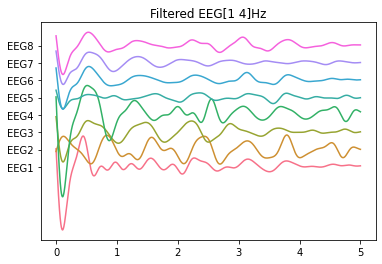

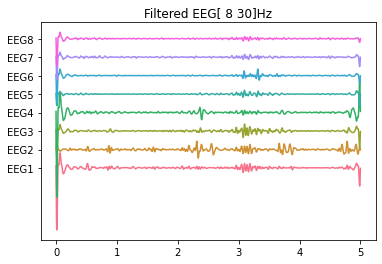

In [13]:
t_skip = 1
samples_skip = t_skip*fs
channels_names = ["EEG1","EEG2","EEG3","EEG4","EEG5","EEG6","EEG7","EEG8"]
eeg_raw_plot = np.zeros((eeg_raw.shape[0],int(eeg_raw.shape[1]-samples_skip)))
channels,T = eeg_raw_plot.shape

for i in range(channels):
    eeg_raw_plot[i,:]=eeg_raw[i,int(samples_skip):]


f_frec = np.array([[1,4],[8,30]])
nf,ff = f_frec.shape
nyq = 0.5 * fs
order = 5
eeg_raw_f = np.zeros((channels,T,nf))

for f in range(nf):
    lfc = f_frec[f,0]
    hfc = f_frec[f,1]            
    low = lfc / nyq
    high = hfc / nyq
    b, a = butter(order, [low, high], btype='band')              
    eeg_raw_f[:,:,f] = filtfilt(b,a,eeg_raw_plot,axis=1) 


for f in range(nf):
    data = eeg_raw_f[:,:,f]  
    plt.figure(f)
    plt.title('Filtered EEG'+str(f_frec[f])+'Hz')
    sca=0.75 
    time = np.linspace(0, data.shape[1] / fs, data.shape[1])
    fig = plt.gcf()
    sumf = sca*np.max(sca*(data-matlib.repmat(data.mean(axis=1).reshape(-1,1),1,data.shape[1])))
    plt.yticks(np.arange(0, sumf*len(channels_names),sumf),channels_names)
    color = sns.color_palette('husl',n_colors=data.shape[0])
    for i in range(data.shape[0]): 
        plt.plot(time, (data[i,:] - data[i,:].mean()) + sumf*i,color=color[i])

## GUIs 

#### GUI-RECORD:
Connection, acquisition, filtering, visualization and EEG data storage in a csv file

In [ ]:
%run -i 'GUI_Record.py'

#### GUI-REPLAY:
Filtering and visualization of EEG data read from a csv file

In [ ]:
%run -i 'GUI_Replay.py'

##  Motor Imagery task
Read data files(gdf) of 4 subjects

Save raw data in a NxM list where N is the subject and M correspond to:
- 0: Activity indices
- 1: Activity markers
- 2: Read raw gdf
- 3: Raw data(X)
- 4: Output data(y)
- 5: Trials of each class
- 6: Identify where the artifacts are located

In [2]:
Xraw_list = []        # raw data list
Xraw_validation_list = []  
subj = [2,3,8,9]      # subjects
Ch = np.arange(0,22)        
clases = [769,770]    # left and right classes
vt = [-1,3.5]         # analysis window : -li:lf stimulus cue


for i in (subj):
    name = 'SavedData/A0' + str(i)
    filename_train = name+'T.gdf'
    i_muestras, i_clases, raw, Xraw, y, ni,m = leer_bci42a_train_full(filename_train,clases,Ch,vt)
    remv_val = [0,1,2,int(ni[0]),int(ni[0]+1)]#Xraw.shape[0]-3,Xraw.shape[0]-2]#,Xraw.shape[0]-1]
    
    Xraw_vector = np.delete(Xraw, remv_val, axis=0)
    y_vector = np.delete(y, remv_val, axis=0)
    
    Xraw_validation = np.zeros((len(remv_val),Xraw.shape[1],Xraw.shape[2]))
    y_validation = np.zeros((len(remv_val)))
    for k in range(len(remv_val)):
        Xraw_validation[k,:,:] = Xraw[remv_val[k],:,:]
        y_validation[k] = y[remv_val[k]]
    
    Xraw_list.append((i_muestras, i_clases, raw, Xraw_vector, y_vector, ni,m))
    Xraw_validation_list.append((Xraw_validation, y_validation))
    print("Subject A0"+str(i)+"T")
    print("Epochs: ",Xraw.shape[0])
    print("Left  trials: ",ni[0])
    print("Right trials: ",ni[1],"\n")
fs = Xraw_list[0][2].info['sfreq'] 
print("Sample frequency:", fs)
print("SamplesxEpoch: ",Xraw.shape[2])
print("TimexEpoch: ",Xraw.shape[2]/fs)
print("Channels: ",Xraw.shape[1])

Extracting EDF parameters from /home/harold/Desktop/Tesis/Memoria_trabajo/SavedData/A02T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Subject A02T
Epochs:  136
Left  trials:  67.0
Right trials:  69.0 

Extracting EDF parameters from /home/harold/Desktop/Tesis/Memoria_trabajo/SavedData/A03T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Subject A03T
Epochs:  137
Left  trials:  69.0
Right trials:  68.0 

Extracting EDF parameters from /home/harold/Desktop/Tesis/Memoria_trabajo/SavedData/A08T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Subject A08T
Epochs:  132
Left  trials:  66.0
Right trials:  66.0 

Extracting EDF parameters from /home/harold/Desktop/Tesis/Memoria_trabajo/SavedData/A09T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Subject A09T
Epochs:  116
Left  trials:  53.0
Right trials:  63.0 

Sample frequ

- Standard montage 10-20

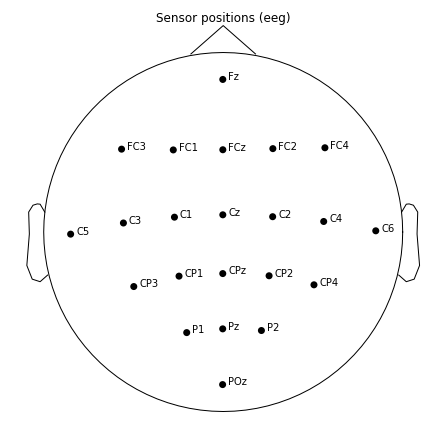

In [3]:
channels_names = ['Fz',
                  'FC3','FC1','FCz','FC2','FC4',
                  'C5','C3','C1','Cz','C2','C4','C6',
                  'CP3','CP1','CPz','CP2','CP4',
                  'P1','Pz','P2',
                  'POz']
montage = mne.channels.read_montage('standard_1020', channels_names)
info = mne.create_info(channels_names, sfreq=250, ch_types="eeg",
                           montage=montage)
mne.viz.plot_sensors(info, show_names=True)
plt.show()

- Viualization of a selected epoch and its respective filtered output 

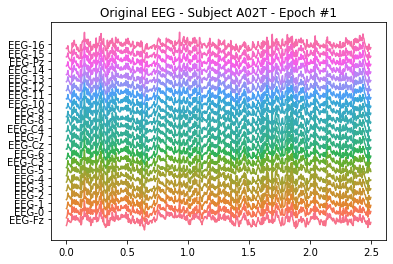

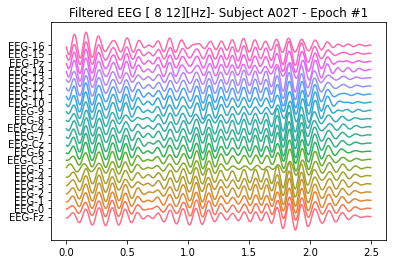

In [65]:
subject = 0                       #Select the subject
ind_epoch = 1                     #Select the epoch
f_frec = np.array([[1,4],[8,12]]) #Bandpass filters
Xrawf = np.squeeze(bank_filter_epochsEEG(Xraw_list[subject][3], fs, f_frec))

plt.figure(1)
plt.title('Original EEG - Subject A0'+str(subj[subject])+'T - Epoch #'+str(ind_epoch))
plot_eeg(data=Xraw_list[subject][3][ind_epoch],sample_rate=fs,channels_names=[raw.ch_names[i] for i in Ch])
plt.savefig('results/OriginalEEG.pdf', dpi=300)
plt.figure(2)
plt.title('Filtered EEG '+str(f_frec[1])+'[Hz]- Subject A0'+str(subj[subject])+'T - Epoch #'+str(ind_epoch))
plot_eeg(data=Xrawf[ind_epoch,:,:,1],sample_rate=fs,channels_names=[raw.ch_names[i] for i in Ch])
plt.savefig('results/FilteredEEG.pdf', dpi=300)

### Common Spatial Patterns(CSP)
- Averaging EEG
- Filter bank
- EEG signal decomposition using the CSP(Xcsp_list)
- Plot the averaged weights used to descompose the data(Topomap)

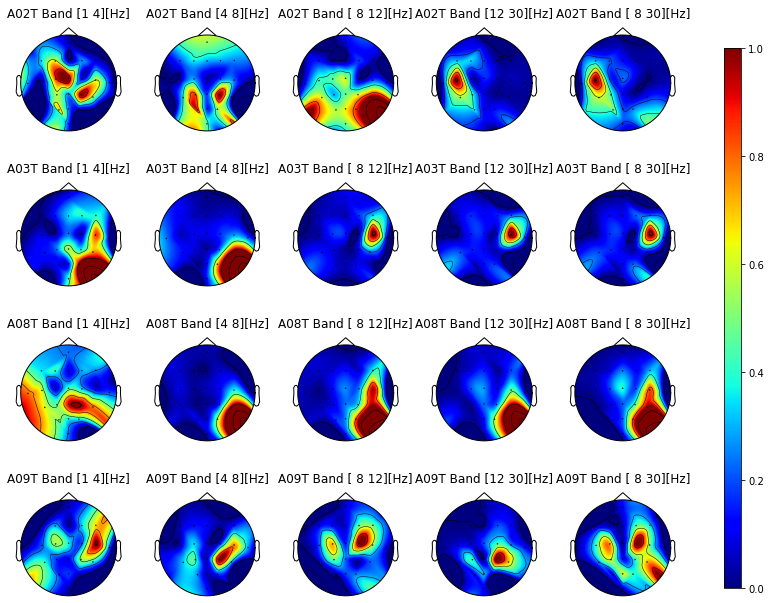

CSP band features:  110


In [5]:
f_frec = np.array([[1,4],[4,8],[8,12],[12,30],[8,30]])
ncomp = Xraw_list[0][3].shape[1]

csp = CSP_epochs_filter_extractor(fs=fs,f_frec=f_frec,ncomp = ncomp,reg='empirical') 
Xcsp_list =[]

f, ax = plt.subplots(len(subj),5,figsize=(12,10))
rhov = np.zeros((22,5))
cmap = 'jet'

for i in range(len(subj)):
    Xcsp =  csp.fit_transform(Xraw_list[i][3],Xraw_list[i][4]) 
    Xcsp_list.append((Xcsp))
    
    for j in range(len(csp.csp_l)):
        rhov[:,j] = abs(csp.csp_l[j].filters_[0]) 
        rhov[:,j] = rhov[:,j]/max(rhov[:,j])
        mne.viz.plot_topomap(rhov[:,j], info, axes=ax[i,j], show=False,cmap=cmap)
        #if i==0:
        ax[i,j].set_title('A0'+str(subj[i])+'T Band '+str(f_frec[j])+'[Hz]')
    
    cax = f.add_axes([0.95, 0.15, 0.02, 0.75])
    norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
plt.legend
plt.colorbar(sm,cax=cax)
plt.savefig('results/Topomaps.pdf', dpi=300)
plt.show()
print("CSP band features: ",Xcsp_list[0].shape[1])

### Pipelining
Sequence of steps in processing the data:
- CSP
- Standardize data
- Classifier

In [67]:
steps = [('rep', CSP_epochs_filter_extractor(fs=fs,f_frec=f_frec,reg='empirical')),
         ('scaler', StandardScaler()), 
        #('cla',  KNeighborsClassifier())] #clasificador 
          ('cla',  GaussianNB())] 
method = Pipeline(steps)          

#Parameters to search by GridSearch
parameters ={'rep__ncomp':[2,4,8,16,Xraw.shape[1]]}

### Nested cross-validation
- Split the data
- Generate and save the best model
- Save accuracy
- Stimate confusion matrix
- Save model using Joblib

In [ ]:
Niter = 10                         #Partitions
acc =np.zeros(Niter)               #Save accuracy
f1 = np.zeros(Niter)

for i in range(len(subj)):
    print('SUBJECT A0'+str(subj[i])+'T')
    Xraw = Xraw_list[i][3]
    y = Xraw_list[i][4]
    Nc = len(np.unique(y))
    cmc = np.zeros((Niter,Nc,Nc))   #Save confusion matrix
    best_estimators = []            #Best method for iteration
    best_parameters = []
    for j in range(Niter):
            print('it %d/%d'%(j+1,Niter))
            X_train, X_test, y_train, y_test = train_test_split(Xraw,y,test_size=0.2, stratify=y)
            grid_search = GridSearchCV(method, parameters,cv=5,verbose=10,scoring='accuracy',n_jobs=4)
            grid_search.fit(X_train,y_train)
        
            y_pred = grid_search.best_estimator_.predict(X_test)
            best_estimators.append(grid_search.best_estimator_)
            best_parameters.append(grid_search.best_params_)
            
            acc[j] = 100*accuracy_score(y_test,y_pred)
            f1[j] = f1_score(y_test,y_pred)
            cm = confusion_matrix(y_test, y_pred)
            cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cmc[j] = cm
            
            print('it %d/%d'%(j+1,Niter))
            print(grid_search.best_params_)
            print('acc:',acc[j])
            print('confusionmatrix \n',cmc[j])
            savedata = {
                'acc':acc,
                'f1score':f1,
                'confusionmatrix':cmc,
                'best_models':best_estimators,
                'best_parameters':best_parameters,
                  } 
            dump(savedata,'results/A0'+str(subj[i])+'TBCI2csp.joblib')

###  Load results
Plot confusion matrix with accuracy and f1 score

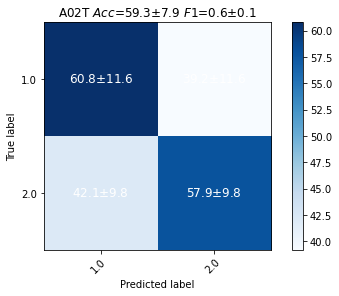

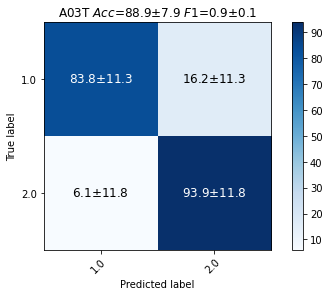

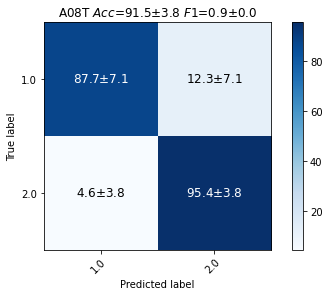

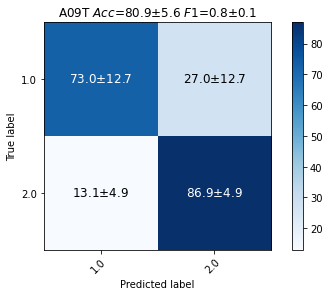

In [71]:
for i in (subj):
    loadeddata = load('results/A0'+str(i)+'TBCI2csp.joblib')
    f1score = loadeddata['f1score']
    acc = loadeddata['acc']
    cmc = loadeddata['confusionmatrix']
    best_estimators = loadeddata['best_models']
    best_parameters = loadeddata['best_parameters']
    plot_confusion_matrix_MS(np.mean(cmc,axis=0), np.std(cmc,axis=0), np.unique(y))
    plt.title('A0'+str(i)+'T ${Acc}$='+ format(np.mean(acc),'.1f') +'$\pm$'+ format(np.std(acc),'.1f')+' ${F1}$='+format(np.mean(f1score),'.1f')+'$\pm$'+ format(np.std(f1score),'.1f'))
    plt.savefig('results/A0'+str(i)+'TConfusionMatrix.pdf', dpi=300, bbox_inches='tight')
    plt.show()

### Generate the model
Find the model to use for the validation task

In [17]:
for i in range(len(subj)):
    print('SUBJECT A0'+str(subj[i])+'T')
    X_train = Xraw_list[i][3]
    y_train = Xraw_list[i][4]
    best_estimators = []            
    best_parameters = []
    
    grid_search = GridSearchCV(method, parameters,cv=5,verbose=10,scoring='accuracy',n_jobs=4)
    grid_search.fit(X_train,y_train)

    
    best_estimators.append(grid_search.best_estimator_)
    best_parameters.append(grid_search.best_params_)

    print(grid_search.best_params_)
    savedata = {
        'best_models':best_estimators,
        'best_parameters':best_parameters,
          } 
    dump(savedata,'results/A0'+str(subj[i])+'TModel.joblib')
    
    

SUBJECT A02T
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   26.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   38.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  21 out of  25 | elapsed:  1.3min remaining:   14.7s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.4min finished


{'rep__ncomp': 2}
SUBJECT A03T
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   31.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   53.7s
[Parallel(n_jobs=4)]: Done  21 out of  25 | elapsed:  1.1min remaining:   12.7s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.2min finished


{'rep__ncomp': 2}
SUBJECT A08T
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   22.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   33.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   56.1s
[Parallel(n_jobs=4)]: Done  21 out of  25 | elapsed:  1.1min remaining:   13.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.3min finished


{'rep__ncomp': 4}
SUBJECT A09T
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   28.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   48.4s
[Parallel(n_jobs=4)]: Done  21 out of  25 | elapsed:   59.0s remaining:   11.2s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.1min finished


{'rep__ncomp': 16}


### Validation 
- Predict the values and move the car through Arduino
- Print accuracy and F1 score

In [58]:
y_pred_list = []

ser = serial.Serial('/dev/ttyUSB0',9600)

for i in range(len(subj)):
    loadeddata = load('results/A0'+str(subj[i])+'TModel.joblib')
    best_estimators = loadeddata['best_models']
    best_parameters = loadeddata['best_parameters']
    for k in range(len(remv_val)):
        y_pred = best_estimators[0].predict(Xraw_validation_list[i][0][k:k+1])
        y_pred_list.append((y_pred[0]))
        ser.write(str(y_pred[0]).encode())
        tm.sleep(2)
    accuracy = 100*accuracy_score(Xraw_validation_list[i][1],y_pred_list)
    f1score = f1_score(Xraw_validation_list[i][1],y_pred_list)
    print("Subject A0"+str(subj[i])+'T')
    print("Accuracy = ",accuracy,"%")
    print("F1 score =",f1score,"\n")
    y_pred_list =[]
ser.close()

Subject A02T
Accuracy =  20.0 %
F1 score = 0.3333333333333333 

Subject A03T
Accuracy =  80.0 %
F1 score = 0.8 

Subject A08T
Accuracy =  100.0 %
F1 score = 1.0 

Subject A09T
Accuracy =  40.0 %
F1 score = 0.5714285714285715 

